# Entrega 1: Entendimiento de los datos

## Introducción
    Estás son las actividades realizadas para lograr el entendimiento de datos para el cliente WWImporters. El documento incluye lo siguiente:
    0. Configuración del entorno y creación de sesión de trabajo
    1. Perfilamiento de datos
    2. Análisis de la calidad de datos
    3. Conclusión del entendimiento de datos
    


## Configuración y creación de sesión de trabajo
Se importan los paquetes requeridos para el análisis y se inicializaza la sesión de trabajo.

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [8]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [11]:
#Configuración de la sesión
#spark.stop()
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

In [12]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_58_202413'
db_psswd = 'aabb1122'

PATH='./'

## Perfilamiento de los datos
El perfilamiento desarrollado aborda los siguientes aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos .


### Información dada por la organización relacionada con los datos
El grupo de consultores de analitica descriptiva de Wide World Importers asegura que las tablas Grupo de compras, Ciudades, Colores, Paises, Clientes, Categorias de clientes, Paquetes, Estados y provincias, Productos y Personas ya fueron perfiladas y corregidos; sin embargo le recomiendan revisar el diccionario suministrado dado que todas las tablas serán utilizadas en futuros requerimientos (tutoriales y ejercicios) que lo encuentra [aqui](./Diccionario%20WWImporters.xlsx). Si tienen alguna duda relacionada con estas tablas deben incluirla en las preguntas o aclaraciones que le entreguen a la organización como parte del resultado de esta fase de entendimiento.

En este punto de la consultorìa, nuestra responsabilidad es analizar las tabla movimientosCopia y nos comentan lo siguiente:

- La cantidad máxima de productos movidos es 50 millones por transacción
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [14]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Carga de datos
Se cargan los datos para las tablas de Movimientos, Proveedores, Clientes y Productos

In [28]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

In [29]:
#Se cargan los dataframes desde la base de datos
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

### Entendimiento general de datos

Se visualiza en forma parcial la información de cada una de las tablas

In [21]:
movimientos.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

A continuación se muestran los esquemas del DataFrame

In [56]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

Analizando el esquema de la tabla de movimientos, podemos encontrar que se encuentra información del producto, del proveedor, del cliente y de la orden de compra. Además se registra el tipo de transacción el identificador de factura la fecha de la transacción y la cantidad.

El identificador de la transacción parece estar definido por el campo TransaccionProductoID pero por la nomenclatura, no está claro.

Realizando una revisión rápida de los datos contenidos, se encuentra algunos aspectos a revizar en detalle más adelante como por ejemplo: cantidades negativas, y referencias vacías a proveedores y a ordenes, además . Por último, la fecha no parece seguir el formato indicado por el cliente. Identificador de proveedor y orden de compra de tipo caracter


A continuación, se imprimen las cantidades de registros y columans de la tabla:

In [39]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9) (19, 27) (19, 9) (19, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 204292 registros de movimientos y 9 variables a revisar de las cuales 3 son nùmericas enteras asociadas a identificados, 3 de tipo numéricas flotantes asociadas a identificadores y campo cantidad y las demás son cadenas de caracteres asociadas a identificadores y campo fecha.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, La cantidad máxima de productos movidos es 50 millones por transacción. 

In [51]:
movimientos.agg({"Cantidad": "max"}).show()

+-------------+
|max(Cantidad)|
+-------------+
|      67368.0|
+-------------+



La máxima cantidad registrada para una transacción es de 67.368 por lo que la primera regla de negocio no es cierta.  

La siguiente regla indica que existen 236.668 movimientos de productos registrados desde el 2013. Como la cantidad total de movimientos es de 204.292, tampoco se cumple.

La siguiente regla indica que hay movimientos registrados con 228.265 cliente.

In [52]:
movimientos.select("ClienteID").distinct().count()

664

Como se puede observar, solo hay 664 clientes distintos en los movimientos registrados proporcionados por lo que tampoco se cumple esta regla

In [ ]:
La siguiente regla indica que el formato de la fecha es de YYYY-MM-DD HH:MM:SS. Entonces para comprobarlo ejecutamos:

57981

In [53]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato de fecha correcto: "+str(cumplenFormato.count()))

Número total de movimientos: 204292, número de movimientos con formato de fecha correcto: 140038


Como se puede observar, del total solo hay 140038 registros qe cumplement con el formato, por lo que la regla solo se cumple para el 68.5% de los movimientos registrados

Por último, se nos indica que hay 13 proveedores distintos. Al verificar con:

In [54]:
movimientos.select("ProveedorID").distinct().count()

4

Por lo que podría tomarse como válido ya que 4 es menor que el máximo que es 13.

Por otro lado, si bien no es una regla del cliente, nos llama la atención la cantidad de tipos de datos distintos para representar las referencias a otras entidades. Entiendo que la organización debe ser notificada para unificar el criterio a aplicar y evitar errores en las relaciones entre entidades distintas. 

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [59]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

En las estadísticas anteriores vemos que las cantidaes de registros son 204.292 como se mencionó anteriormente. La media y la desviación estandarsolo tiene sentido analizarla para el campo Cantidad que es de casi 719.5 y 4729.37 respectivamente. En cuanto al valor mínimo, las columnas ClienteID y ProveedoID tienen como valor mínimo 0.0 lo cuál es extraño ya que son identificadores de entidades. También aparecen registros de movimientos sin referencias a proveedores y ordenes de compra El valor mínimo de cantidad es negativo lo cuál debería ser un error a comunicar ya que las cantidades siempre tienen que ser positivas. Con respecto al resto de los valores, solo destacar nuevamente la gran cantidad de registros con cantidades negativas y las diferencias entre el mínimo y máximo valor de los identificadores encontrados.

Para tener un análisis más detallado de la variable Cantidad, utilizaremos el  los siguiente diagrams de caja donde se observa claramente que tenemos un valor extremo en la variable cantidad y donde podemos ver los valores extremos o bigotes que determinan el punto de separación entre valores atípicos y normales, los valores atipicos, los cuartiles entre otros

{'whiskers': [<matplotlib.lines.Line2D at 0x209a5dd86c8>,
 'caps': [<matplotlib.lines.Line2D at 0x209a5624b08>,
 'boxes': [<matplotlib.lines.Line2D at 0x209aafcc888>],
 'medians': [<matplotlib.lines.Line2D at 0x209a8ea6208>],
 'fliers': [<matplotlib.lines.Line2D at 0x209a8ea6848>],
 'means': []}

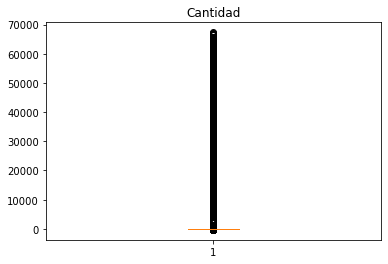

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))

## Análisis de calidad de datos
En este análisis se resalta:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [68]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
        else:
            print('número de no vacíos para columna '+c+': '+str( vacios ))
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [69]:
contar_vacios(movimientos)

número de no vacíos para columna TransaccionProductoID: 0
número de no vacíos para columna ProductoID: 0
número de no vacíos para columna TipoTransaccionID: 0
número de no vacíos para columna ClienteID: 0
número de no vacíos para columna InvoiceID: 0
número de no vacíos para columna ProveedorID: 0
número de no vacíos para columna OrdenDeCompraID: 0
número de no vacíos para columna FechaTransaccion: 0
número de no vacíos para columna Cantidad: 0


[]

In [72]:
cardinalidad(movimientos)

{'TransaccionProductoID': 173659}

Como podemos observar para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 13750 vacios, ID_de_pedido_pendiente: 79035, Comentarios: 88258, Instrucciones_de_entrega: 88258, Comentarios_internos: 88258, Seleccion_completada_cuando: 4347, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 983 y Seleccion_completada_cuando: 982. 

Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [ ]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

(44359, 28956)

Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [ ]:
reporte = ProfileReport(ordenes.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Lo primero que hay que notar es que hay 3 secciones principales. La primera es un resumen, la segunda es un análisis por cada variable y luego tenemos interacciones y correlaciones entre variables. 

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de interacciones y correlaciones:

Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

<b>Cabe aclarar que un pandas profiling sin interpretación no es suficiente como análisis para realizar el entendimiento de los datos.

Así mismo, recuerde que si es necesario, se debe utilizar otra herramienta (código, visualizaciones, etc) para poder completar el análisis estadístico.</b>

### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'Cantidad_seleccionada'}>]],
      dtype=object)

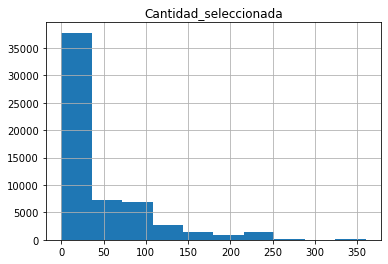

In [ ]:
#para valores extremos(subir a calidad)
detallesOrdenes.toPandas().hist(column='Cantidad_seleccionada')

In [ ]:
cantidades = detallesOrdenes.groupby("Cantidad").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

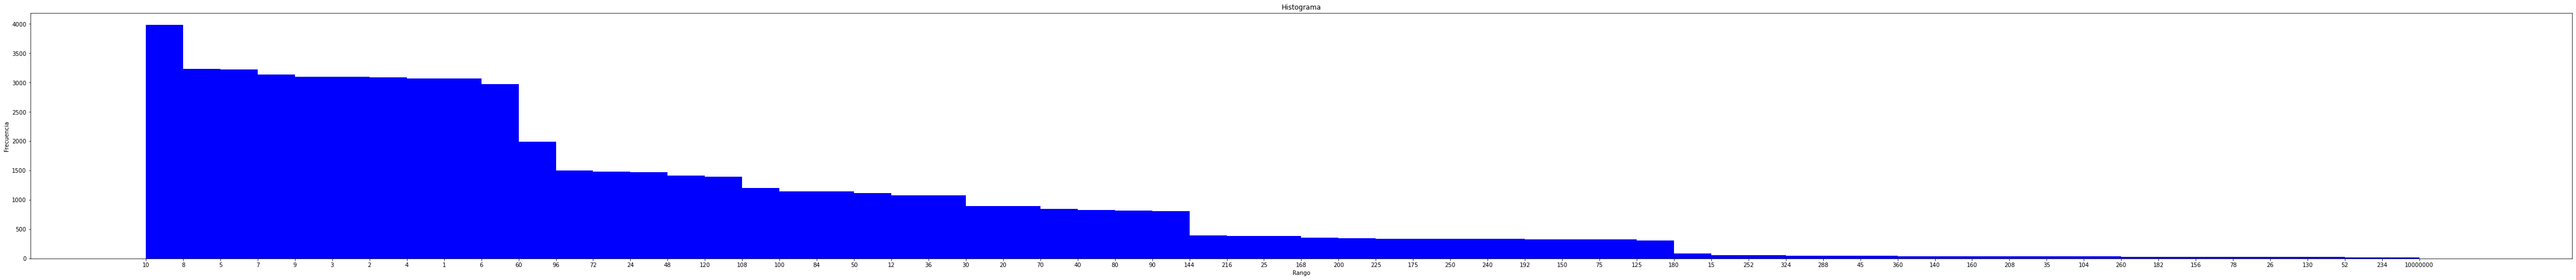

In [ ]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantidades)

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

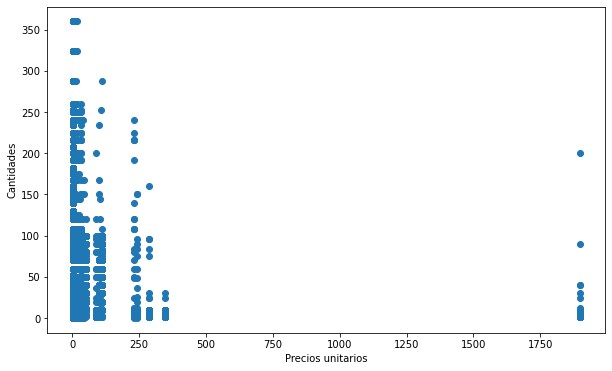

In [ ]:
unitPrices = [row['Precio_unitario'] for row in detallesOrdenes.select(col('Precio_unitario')).collect()]
quantities = [row['Cantidad_seleccionada'] for row in detallesOrdenes.collect()]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = unitPrices, y = quantities)
plt.xlabel("Precios unitarios")
plt.ylabel("Cantidades")

plt.show()

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [ ]:
ordenes.groupBy('Fecha_de_pedido').pivot('ID_de_vendedor').count().show()

+---------------+----+---+---+----+----+----+---+----+---+----+
|Fecha_de_pedido|   2|  3|  6|   7|   8|  13| 14|  15| 16|  20|
+---------------+----+---+---+----+----+----+---+----+---+----+
|     2014-12-13|   7|  8|  7|   5|   3|   6|  7|   6|  2|   6|
|     2014-05-27|   6|  7|  8|   6|   2|  11|  6|   5| 13|   6|
|     2014-02-22|   6|  4|  2|   6|   4|   3|  2|null| 11|   7|
|     2015-05-01|  22| 13| 17|   2|  14|  13|  9|  11| 19|  16|
|    Feb 27,2014|   5|  3|  6|   1|   3|null|  3|   3|  7|   1|
|     2015-02-09|   2| 13| 15|  18|   8|   6|  6|   7| 15|  15|
|    Sep 21,2015|   2|  6|  7|   6|   2|   2|  3|   3|  3|   2|
|     2014-07-14|  13| 10| 15|   7|   5|  13| 15|  10| 17|  12|
|    Jul 26,2014|   2|  2|  3|   3|   1|   1|  3|null|  1|   2|
|    May 14,2016|null|  3|  2|   5|   1|   4|  3|null|  1|   3|
|    Aug 22,2015|   1|  1|  2|   4|null|   2|  2|   2|  5|   1|
|     2014-12-11|  13| 18|  4|   4|   9|  10|  2|  11|  5|   2|
|     2015-02-27|  19| 14| 10|  10|  22|

Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

In [ ]:
corr = detallesOrdenes.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

C:\ProgramData\Anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\ProgramData\Anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Detalle_orden_ID,ID_de_pedido,ID_Producto,ID_Tipo_Paquete,Cantidad,Cantidad_seleccionada
Detalle_orden_ID,1.000000,0.052772,0.022949,nan,0.003160,0.003761
ID_de_pedido,0.052772,1.000000,-0.007438,nan,-0.003613,-0.008976
ID_Producto,0.022949,-0.007438,1.000000,nan,0.002252,0.513602
ID_Tipo_Paquete,nan,nan,nan,nan,nan,nan
Cantidad,0.003160,-0.003613,0.002252,nan,1.000000,-0.001033
Cantidad_seleccionada,0.003761,-0.008976,0.513602,nan,-0.001033,1.000000


## Conclusiones/resultados


**Conclusiones generales:**

1. En la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**
2. Una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.
3. ¿cuál es la diferencia entre cantidad y cantidad seleccionada?

**Conclusiones de reglas de negocio:**

1. La regla 1 no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento
2. La regla 2 no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, Hay 14.079 ordenes completamente repetidas y 258 registros que representan el mismo detalle de orden pero con valores distintos, los primeros se pueden eliminar, pero ¿qué deberíamos hacer con los segundos?
3. Los datos comienzan en enero 1 de 2014, sin embargo la regla 2 nos dice que debería ser desde 2013, ¿es un error o faltan datos?
4. Algunos formatos de fecha no coinciden con el dado en la regla 3, por ejemplo del atributo Fecha_de_pedido hay 20 mil registros que no tienen ese formato. En este caso el cambio de formato se puede implementar, ¿estan de acuerdo?
5. La descripcion de algunos productos es "a", ¿esto es correcto?

**Conclusiones de calidad:**

1. Las columnas Comentarios, Instrucciones_de_entrega y Comentarios_internos tienen un conteo igual a 0, es decir son columnas vacías por lo que se pueden eliminar
2. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era 60, es decir, para el 75% de los datos, el valor de Cantidad no superaba el 70, pero el valor máximo es de 10 millones
3. Observamos que la columna ID_Tipo_Paquete solo toma el valor 7, que podría ser o no un error, se notifica al negocio.
4. Para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 16662 vacios, ID_de_pedido_pendiente: 96905, Comentarios: 108291, Instrucciones_de_entrega: 108291, Comentarios_internos: 108291, Seleccion_completada_cuando: 5276, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 7038 y Seleccion_completada_cuando: 3186.
5. Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.
6. Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. ¿Tienen alguna forma de identificar cual detalle corresponde a cual orden?

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de correlación:

13. Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

**Conclusiones de consultoria**

![Requerimiento](./Requerimiento.PNG)

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio

Para comprobar su comprensión de esta sección, lo invitamos a responder la pregunta:

    ¿Qué funcionalidades de PySpark puedo utilizar para realizar el entendimiento de datos y cómo las puedo utilizar?
    
Como parte de nuestro trabajo es preveer posibles soluciones a las conclusiones de perfilamiento, por ende lo invitamos a responder:

    ¿Qué métodos podría utilizar para reemplazar los valores nulos de una columna por el promedio de la misma?

# 5. Tarea
Espacio para desarrollar la tarea propuesta 

### Perfilamiento de datos

### Análisis de calidad de datos

### Conclusiones

## Cierre

Completado este tutorial ya sabrá la forma básica de utilizar PySpark. Ya sabe cómo crear DataFrames a partir de datos existentes, cómo seleccionar columnas o filas de este Dataframe, cómo rellenar espacios vacíos, cómo aplicar sus propias funciones a estos datos y los más importante, cómo utilizarlo para realizar una fase de entendimiento de datos.

Las tablas detallesOrdenesCopia y OrdenesCopia estaran disponibles en caso de que desee repetir este tutorial cuantas veces considere necesario

## 7. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 8. Preguntas frecuentes

1. Si en el cálculo de los histogramas o en una de sus UDF obtiene el error: TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float' verifique los tipos de las columnas que está intentando operar y, si alguna es double, conviértala a float.

2. En algunos casos, encontrará también información sobre <i>Pandas_UDF</i>. <i>Pandas_UDF</i> son también User Defined Functions, por lo general los Pandas UDF son más eficientes que los UDF tradicionales, sin embargo, hay un bug con la versión de PySpark y de Java que se está usando, lo que previene la utilización de Pandas_UDF.

3. Si al ejecutar la configuración de la sesión Spark le aparece el error <i>Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*])</i> Reinicie el kernel y vuelva a ejecutar
